In [ ]:
'''
Env: python 3.9
Reads from: /scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation/
calculates A0 by min{Column LWA}
'''

In [1]:
import numpy as np

# Load the .npy file
data = np.load('/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation/column_LWA_1990_1990_04_06_06.npy')

# Print the shape of the data
print(data.shape)


(121, 240)


Computing min array: 100%|██████████| 55063/55063 [00:03<00:00, 16323.31it/s]


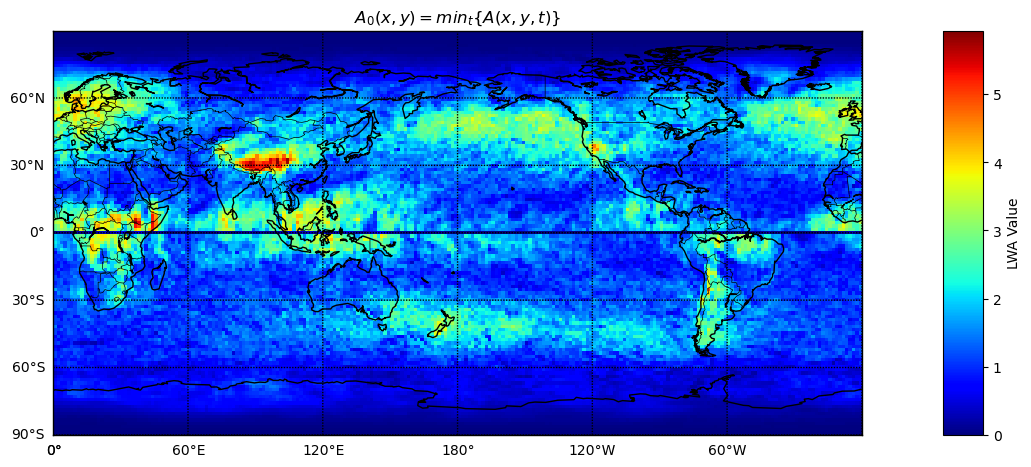

In [6]:
# All year min LWA

import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

# Load and return the minimum array for the given file
def process_file(file_name):
    return np.load(os.path.join(output_directory, file_name))

# 1. List all files starting with 'column_LWA_' from the directory
output_directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
file_names = [f for f in os.listdir(output_directory) if f.startswith('column_LWA_') and f.endswith('.npy')]

if not file_names:
    print("No 'column_LWA_' files found.")
    exit()

# 2. Parallelized loading of files and computing min_array
with Pool(processes=cpu_count()) as pool:
    arrays = list(tqdm(pool.imap(process_file, file_names), total=len(file_names), desc="Loading files"))

# Initialize min_array from the first loaded file
min_array = arrays[0]

# 3. For each 2D coordinate, find the minimum value across all loaded arrays
for array in tqdm(arrays[1:], desc="Computing min array"):
    min_array = np.minimum(min_array, array)

# 4. Save the minimum values as a new Numpy array
np.save(os.path.join(output_directory, "dist_of_A0.npy"), min_array)

# 5. Plot these minimum values as a 2D heatmap on a world map
fig = plt.figure(figsize=(12, 6))

# Create a basemap instance
m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360)

# Convert latitude and longitude to 2D grid. Add extra point for 'flat' shading mode
lon = np.linspace(0, 360, min_array.shape[1] + 1)
lat = np.linspace(-90, 90, min_array.shape[0] + 1)
Lon, Lat = np.meshgrid(lon, lat)

# Draw continents, coastlines, countries, and boundaries
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()
parallels = np.arange(-90., 90., 30.)
m.drawparallels(parallels, labels=[1,0,0,0], fontsize=10)
meridians = np.arange(0., 360., 60.)
m.drawmeridians(meridians, labels=[0,0,0,1], fontsize=10)


# Display the heatmap
cs = m.pcolormesh(Lon, Lat, min_array, shading='flat', cmap='jet', latlon=True)


# Add colorbar
cbar = m.colorbar(cs, location='right', pad="10%")
cbar.set_label('LWA Value')

# Set title
plt.title("$A_0 (x,y) = min_t\{A(x,y,t)\}$")

plt.show()


Loading files: 100%|██████████| 55064/55064 [00:19<00:00, 2794.47it/s]


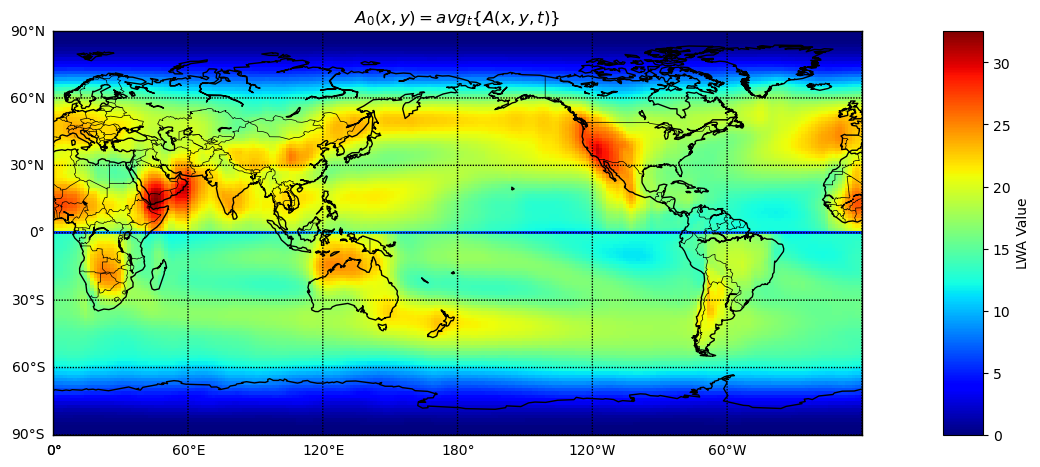

In [1]:
# All year mean LWA

import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

# Load the given file and return its content
def process_file(file_name):
    return np.load(os.path.join(output_directory, file_name))

output_directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
file_names = [f for f in os.listdir(output_directory) if f.startswith('column_LWA_') and f.endswith('.npy')]

if not file_names:
    print("No 'column_LWA_' files found.")
    exit()

# Parallelized loading of files
with Pool(processes=cpu_count()) as pool:
    arrays = list(tqdm(pool.imap(process_file, file_names), total=len(file_names), desc="Loading files"))

# Compute the mean of LWA across all files
sum_array = np.zeros_like(arrays[0])
for array in arrays:
    sum_array += array
mean_array = sum_array / len(arrays)

# Save the minimum values as a new Numpy array
np.save(os.path.join("/depot/wanglei/etc/KenYan_Traffic_Model/hn2016-falwa_calculation/", "dist_of_LWA_2Dmean.npy"), mean_array)

# Plotting the mean values on a world map with longitude and latitude labels
fig = plt.figure(figsize=(12, 6))
m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360)

# Convert latitude and longitude to 2D grid. Add an extra point for 'flat' shading mode
lon = np.linspace(0, 360, mean_array.shape[1] + 1)
lat = np.linspace(-90, 90, mean_array.shape[0] + 1)
Lon, Lat = np.meshgrid(lon, lat)

m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()

# Draw longitude and latitude labels
parallels = np.arange(-90., 91., 30.)
m.drawparallels(parallels, labels=[1,0,0,0], fontsize=10)
meridians = np.arange(0., 361., 60.)
m.drawmeridians(meridians, labels=[0,0,0,1], fontsize=10)

# Display the heatmap for the mean values
cs = m.pcolormesh(Lon, Lat, mean_array, shading='flat', cmap='jet', latlon=True)

# Add colorbar
cbar = m.colorbar(cs, location='right', pad="10%")
cbar.set_label('LWA Value')

# Set title
plt.title("$A_0 (x,y) = avg_t\{A(x,y,t)\}$")

plt.show()


Computing min array: 100%|██████████| 13605/13605 [00:00<00:00, 33346.89it/s]


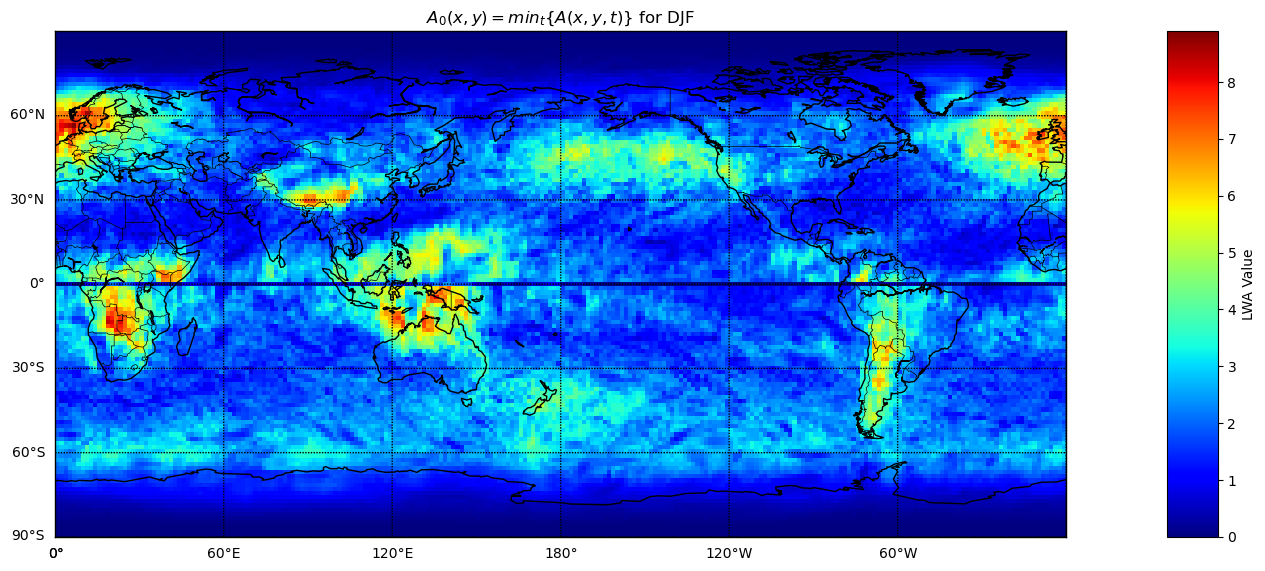

In [9]:
# Winter min LWA

import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import re  # Import the regex library

# Load and return the minimum array for the given file
def process_file(file_name):
    return np.load(os.path.join(output_directory, file_name))

# Filter filenames to only include winter months
def is_winter_file(filename):
    match = re.search(r'_(\d{4})_(\d{2})_', filename)
    if match:
        month = match.group(2)
        if month in ['01', '02', '12']:
            return True
    return False

# 1. List all files starting with 'column_LWA_' from the directory
output_directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
file_names = [f for f in os.listdir(output_directory) if f.startswith('column_LWA_') and f.endswith('.npy') and is_winter_file(f)]

if not file_names:
    print("No 'column_LWA_' winter files found.")
    exit()

# 2. Parallelized loading of files and computing min_array
with Pool(processes=cpu_count()) as pool:
    arrays = list(tqdm(pool.imap(process_file, file_names), total=len(file_names), desc="Loading files"))

# Initialize min_array from the first loaded file
min_array = arrays[0]

# 3. For each 2D coordinate, find the minimum value across all loaded arrays
for array in tqdm(arrays[1:], desc="Computing min array"):
    min_array = np.minimum(min_array, array)

# 4. Save the minimum values as a new Numpy array
np.save(os.path.join(output_directory, "dist_of_A0_winter.npy"), min_array)

# 5. Plot these minimum values as a 2D heatmap on a world map
fig = plt.figure(figsize=(15, 7))

# Create a basemap instance
m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360)

# Convert latitude and longitude to 2D grid. Add extra point for 'flat' shading mode
lon = np.linspace(0, 360, min_array.shape[1] + 1)
lat = np.linspace(-90, 90, min_array.shape[0] + 1)
Lon, Lat = np.meshgrid(lon, lat)

# Draw continents, coastlines, countries, and boundaries
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()
parallels = np.arange(-90., 90., 30.)
m.drawparallels(parallels, labels=[1,0,0,0], fontsize=10)
meridians = np.arange(0., 360., 60.)
m.drawmeridians(meridians, labels=[0,0,0,1], fontsize=10)


# Display the heatmap
cs = m.pcolormesh(Lon, Lat, min_array, shading='flat', cmap='jet', latlon=True)


# Add colorbar
cbar = m.colorbar(cs, location='right', pad="10%")
cbar.set_label('LWA Value')

# Set title
plt.title("$A_0 (x,y) = min_t\{A(x,y,t)\}$ for DJF")

plt.show()



Loading files: 100%|██████████| 13606/13606 [08:52<00:00, 25.57it/s]


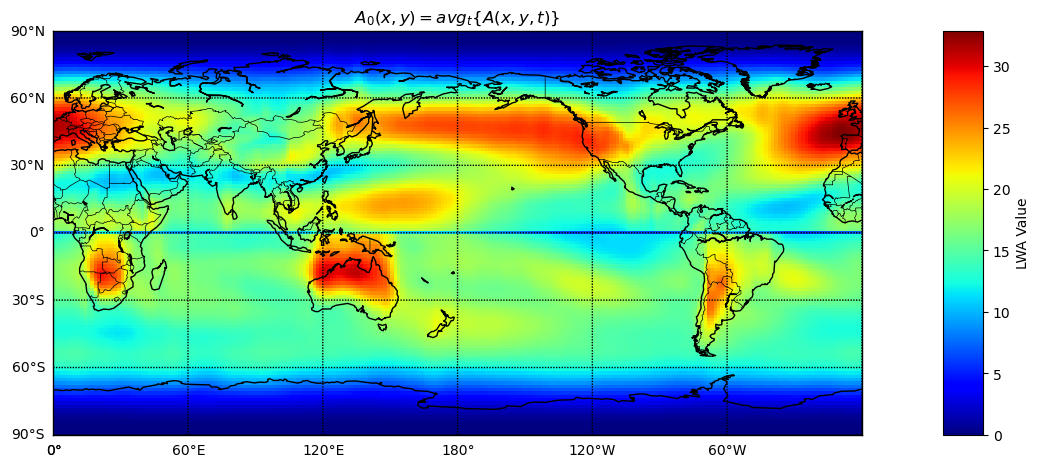

In [1]:
# Winter mean LWA

import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import re 

# Load the given file and return its content
def process_file(file_name):
    return np.load(os.path.join(output_directory, file_name))

# Filter filenames to only include winter months
def is_winter_file(filename):
    match = re.search(r'_(\d{4})_(\d{2})_', filename)
    if match:
        month = match.group(2)
        if month in ['01', '02', '12']:
            return True
    return False

# 1. List all files starting with 'column_LWA_' from the directory
output_directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
file_names = [f for f in os.listdir(output_directory) if f.startswith('column_LWA_') and f.endswith('.npy') and is_winter_file(f)]


if not file_names:
    print("No 'column_LWA_' files found.")
    exit()

# Parallelized loading of files
with Pool(processes=cpu_count()) as pool:
    arrays = list(tqdm(pool.imap(process_file, file_names), total=len(file_names), desc="Loading files"))

# Compute the mean of LWA across all files
sum_array = np.zeros_like(arrays[0])
for array in arrays:
    sum_array += array
mean_array = sum_array / len(arrays)

# Save the minimum values as a new Numpy array
np.save(os.path.join("/depot/wanglei/etc/KenYan_Traffic_Model/hn2016-falwa_calculation/", "dist_of_LWA_2Dmean_winter.npy"), mean_array)

# Plotting the mean values on a world map with longitude and latitude labels
fig = plt.figure(figsize=(12, 6))
m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360)

# Convert latitude and longitude to 2D grid. Add an extra point for 'flat' shading mode
lon = np.linspace(0, 360, mean_array.shape[1] + 1)
lat = np.linspace(-90, 90, mean_array.shape[0] + 1)
Lon, Lat = np.meshgrid(lon, lat)

m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()

# Draw longitude and latitude labels
parallels = np.arange(-90., 91., 30.)
m.drawparallels(parallels, labels=[1,0,0,0], fontsize=10)
meridians = np.arange(0., 361., 60.)
m.drawmeridians(meridians, labels=[0,0,0,1], fontsize=10)

# Display the heatmap for the mean values
cs = m.pcolormesh(Lon, Lat, mean_array, shading='flat', cmap='jet', latlon=True)

# Add colorbar
cbar = m.colorbar(cs, location='right', pad="10%")
cbar.set_label('LWA Value')

# Set title
plt.title("$A_0 (x,y) = avg_t\{A(x,y,t)\}$")

plt.show()


Loading and processing files: 100%|██████████| 13720/13720 [19:09<00:00, 11.94it/s]


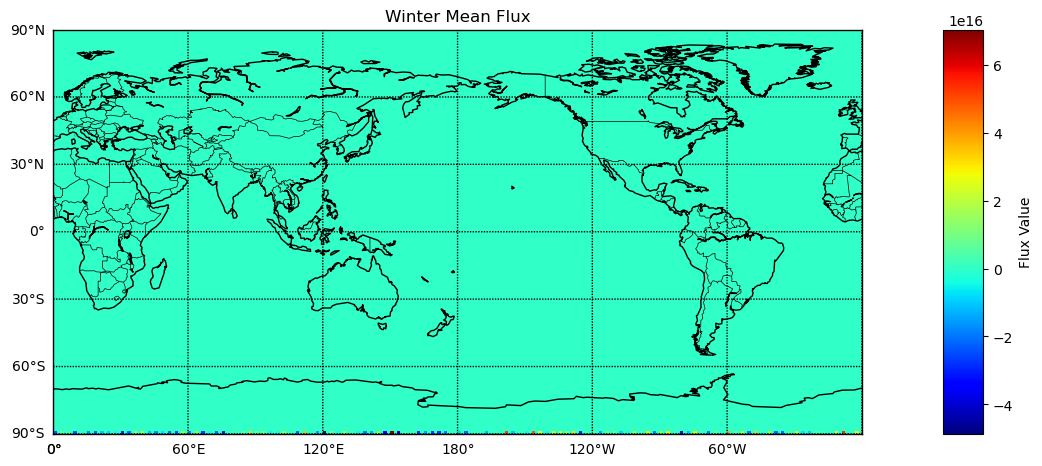

In [6]:
# 20240606 Calculate Mean Flux

import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import re

# Adjusted function to load and sum the flux data (F1, F2, F3)
def process_file(file_name):
    # Corrected regex pattern: Removed the unbalanced parenthesis and unnecessary capture group for year
    year, year2, month, day, hour = re.search(r'F1_(\d{4})_(\d{4})_(\d{2})_(\d{2})_(\d{2})', file_name).groups()
    return load_flux_data(year, month, day, hour)

# Filter filenames to only include winter months for the flux files
def is_winter_file(filename):
    match = re.search(r'_(\d{4})_(\d{2})_', filename)
    if match:
        month = int(match.group(2))
        return month in [1, 2, 12]
    return False

# Function to load flux data for a given time
def load_flux_data(year, month, day, hour):
    """
    Load flux data (F1, F2, F3) for a given date and time, and return their sum.
    The file name is expected to be in the format F1_YYYY_YYYY_MM_DD_HH.npy.
    """
    base_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
    f1_file = os.path.join(base_path, f"F1_{year}_{year}_{month}_{day}_{hour}.npy")
    f2_file = os.path.join(base_path, f"F2_{year}_{year}_{month}_{day}_{hour}.npy")
    f3_file = os.path.join(base_path, f"F3_{year}_{year}_{month}_{day}_{hour}.npy")

    f1 = np.load(f1_file)
    f2 = np.load(f2_file)
    f3 = np.load(f3_file)
    
    return f1 + f2 + f3

output_directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
file_names = [f for f in os.listdir(output_directory) if f.startswith('F1_') and f.endswith('.npy') and is_winter_file(f)]

if not file_names:
    print("No flux files found.")
    exit()

# Parallelized loading and processing of files
with Pool(processes=cpu_count()) as pool:
    arrays = list(tqdm(pool.imap(process_file, file_names), total=len(file_names), desc="Loading and processing files"))

# Compute the mean of the flux data across all files
sum_array = np.zeros_like(arrays[0])
for array in arrays:
    sum_array += array
mean_array = sum_array / len(arrays)

# Save the mean values as a new Numpy array
np.save(os.path.join("/depot/wanglei/etc/KenYan_Traffic_Model/hn2016-falwa_calculation/", "mean_flux_winter.npy"), mean_array)

# Plotting (this part can remain mostly unchanged)
fig = plt.figure(figsize=(12, 6))
m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360)
lon = np.linspace(0, 360, mean_array.shape[1] + 1)
lat = np.linspace(-90, 90, mean_array.shape[0] + 1)
Lon, Lat = np.meshgrid(lon, lat)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()
parallels = np.arange(-90., 91., 30.)
m.drawparallels(parallels, labels=[1,0,0,0], fontsize=10)
meridians = np.arange(0., 361., 60.)
m.drawmeridians(meridians, labels=[0,0,0,1], fontsize=10)
cs = m.pcolormesh(Lon, Lat, mean_array, shading='flat', cmap='jet', latlon=True)
cbar = m.colorbar(cs, location='right', pad="10%")
cbar.set_label('Flux Value')
plt.title("Winter Mean Flux")
plt.show()



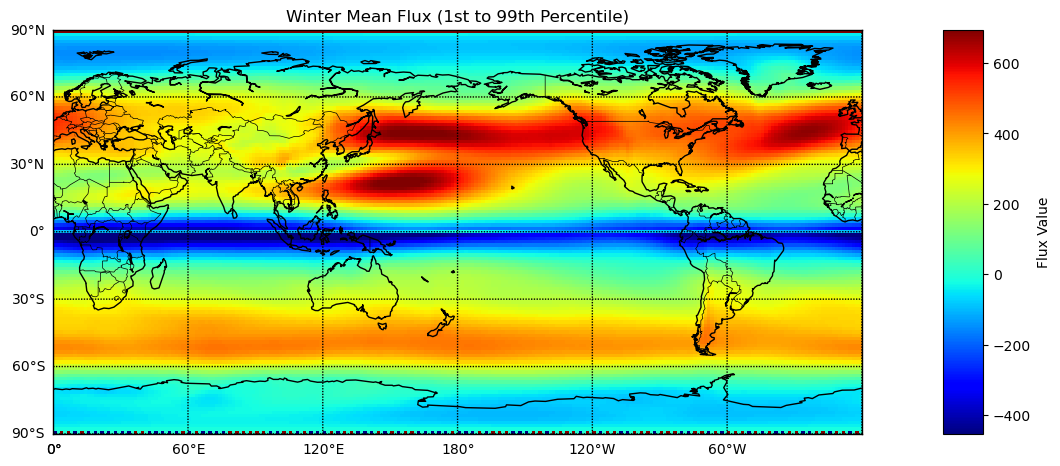

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Load the mean flux array if not already loaded
# mean_array = np.load('/path_to_saved_mean_array/mean_flux_winter.npy')

# Calculate the 1% and 99% percentiles to limit the color scale
percentile_1 = np.percentile(mean_array, 1)
percentile_99 = np.percentile(mean_array, 99)

# Plotting configuration
fig = plt.figure(figsize=(12, 6))
m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360)
lon = np.linspace(0, 360, mean_array.shape[1] + 1)
lat = np.linspace(-90, 90, mean_array.shape[0] + 1)
Lon, Lat = np.meshgrid(lon, lat)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()
parallels = np.arange(-90., 91., 30.)
m.drawparallels(parallels, labels=[1,0,0,0], fontsize=10)
meridians = np.arange(0., 361., 60.)
m.drawmeridians(meridians, labels=[0,0,0,1], fontsize=10)

# Draw the color mesh, using the percentile limits for the color range
cs = m.pcolormesh(Lon, Lat, mean_array, shading='flat', cmap='jet', latlon=True, vmin=percentile_1, vmax=percentile_99)

# Add a color bar with the label
cbar = m.colorbar(cs, location='right', pad="10%")
cbar.set_label('Flux Value')

# Set the title
plt.title("Winter Mean Flux (1st to 99th Percentile)")
plt.show()


Loading files: 100%|██████████| 13606/13606 [00:08<00:00, 1653.01it/s]


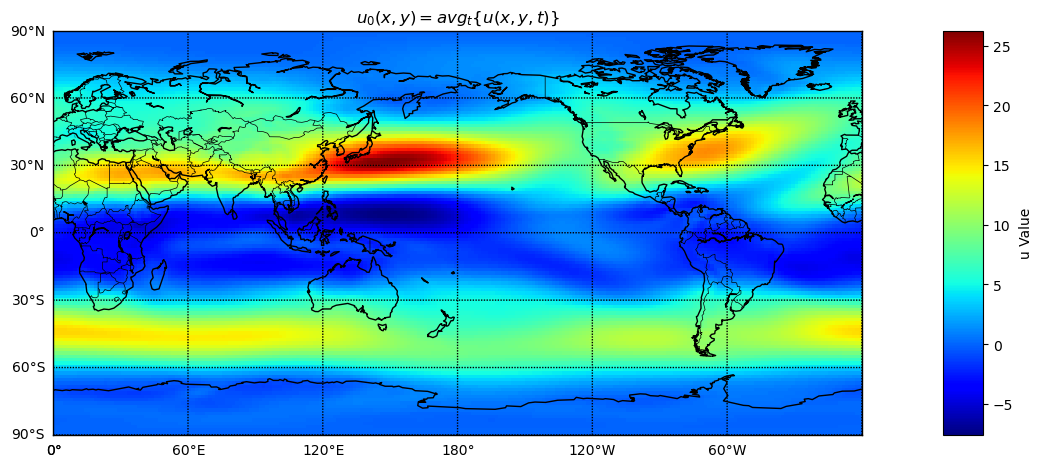

In [1]:
# mean winter zonal wind

import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import re 

# Load the given file and return its content
def process_file(file_name):
    return np.load(os.path.join(output_directory, file_name))

# Filter filenames to only include winter months
def is_winter_file(filename):
    match = re.search(r'_(\d{4})_(\d{2})_', filename)
    if match:
        month = match.group(2)
        if month in ['01', '02', '12']:
            return True
    return False

# 1. List all files starting with 'column_LWA_' from the directory
output_directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
file_names = [f for f in os.listdir(output_directory) if f.startswith('column_zonal_wind_u_') and f.endswith('.npy') and is_winter_file(f)]


if not file_names:
    print("No 'column_zonal_wind_u_' files found.")
    exit()

# Parallelized loading of files
with Pool(processes=cpu_count()) as pool:
    arrays = list(tqdm(pool.imap(process_file, file_names), total=len(file_names), desc="Loading files"))

# Compute the mean of LWA across all files
sum_array = np.zeros_like(arrays[0])
for array in arrays:
    sum_array += array
mean_array = sum_array / len(arrays)

# Save the minimum values as a new Numpy array
np.save(os.path.join(output_directory, "dist_of_zonal_wind_u_mean_winter.npy"), mean_array)

# Plotting the mean values on a world map with longitude and latitude labels
fig = plt.figure(figsize=(12, 6))
m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360)

# Convert latitude and longitude to 2D grid. Add an extra point for 'flat' shading mode
lon = np.linspace(0, 360, mean_array.shape[1] + 1)
lat = np.linspace(-90, 90, mean_array.shape[0] + 1)
Lon, Lat = np.meshgrid(lon, lat)

m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()

# Draw longitude and latitude labels
parallels = np.arange(-90., 91., 30.)
m.drawparallels(parallels, labels=[1,0,0,0], fontsize=10)
meridians = np.arange(0., 361., 60.)
m.drawmeridians(meridians, labels=[0,0,0,1], fontsize=10)

# Display the heatmap for the mean values
cs = m.pcolormesh(Lon, Lat, mean_array, shading='flat', cmap='jet', latlon=True)

# Add colorbar
cbar = m.colorbar(cs, location='right', pad="10%")
cbar.set_label('u Value')

# Set title
plt.title("$u_0 (x,y) = avg_t\{u(x,y,t)\}$")

plt.show()


Loading files: 100%|██████████| 13606/13606 [00:04<00:00, 2815.48it/s]


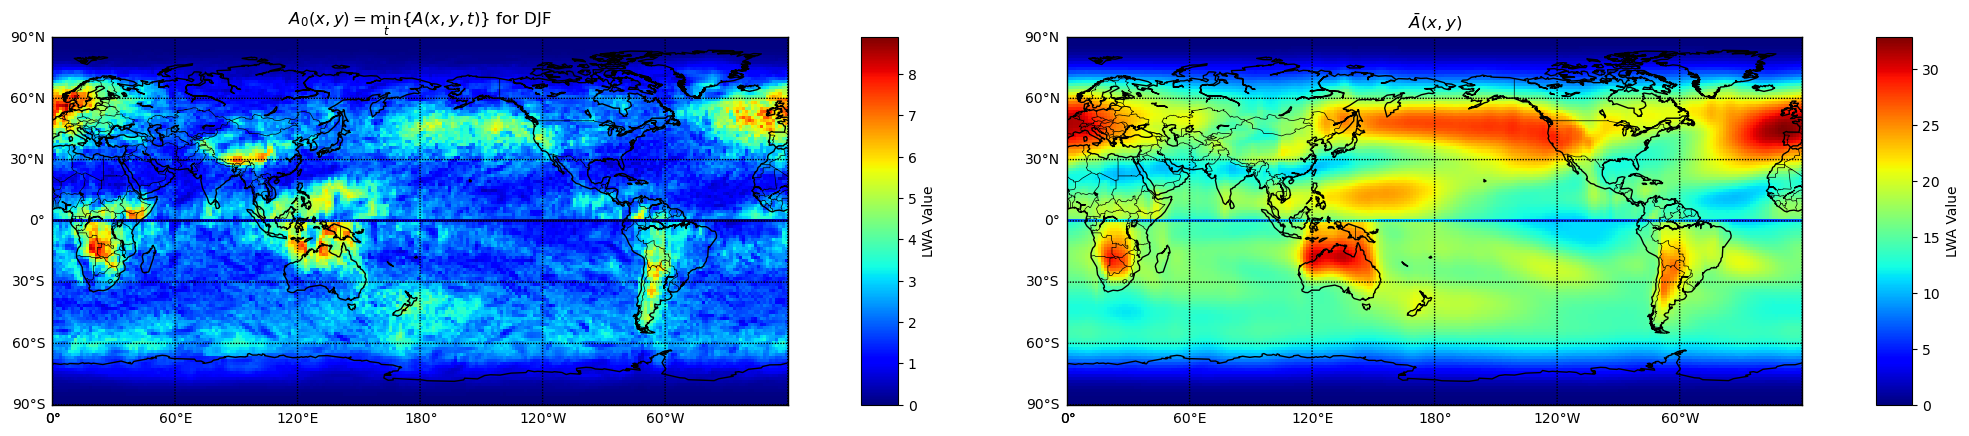

In [4]:
## appendix fig
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import re

# Load the given file and return its content
def process_file(file_name):
    return np.load(os.path.join(output_directory, file_name))

# Filter filenames to only include winter months
def is_winter_file(filename):
    match = re.search(r'_(\d{4})_(\d{2})_', filename)
    if match:
        month = match.group(2)
        if month in ['01', '02', '12']:
            return True
    return False

# 1. List all files starting with 'column_LWA_' from the directory
output_directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
file_names = [f for f in os.listdir(output_directory) if f.startswith('column_LWA_') and f.endswith('.npy') and is_winter_file(f)]

if not file_names:
    print("No 'column_LWA_' files found.")
    exit()

# Parallelized loading of files
with Pool(processes=cpu_count()) as pool:
    arrays = list(tqdm(pool.imap(process_file, file_names), total=len(file_names), desc="Loading files"))

# Compute the mean and minimum of LWA across all files
min_array = arrays[0]
sum_array = np.zeros_like(arrays[0])
for array in arrays:
    min_array = np.minimum(min_array, array)
    sum_array += array
mean_array = sum_array / len(arrays)

# Save the results as new Numpy arrays
np.save(os.path.join(output_directory, "dist_of_A0_winter_min.npy"), min_array)
np.save(os.path.join(output_directory, "dist_of_A0_winter_mean.npy"), mean_array)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))

# Function to set up a Basemap and plot data
def plot_data(ax, data, title):
    m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360, ax=ax)
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary()
    parallels = np.arange(-90., 91., 30.)
    m.drawparallels(parallels, labels=[1,0,0,0], fontsize=10)
    meridians = np.arange(0., 361., 60.)
    m.drawmeridians(meridians, labels=[0,0,0,1], fontsize=10)
    lon = np.linspace(0, 360, data.shape[1] + 1)
    lat = np.linspace(-90, 90, data.shape[0] + 1)
    Lon, Lat = np.meshgrid(lon, lat)
    cs = m.pcolormesh(Lon, Lat, data, shading='flat', cmap='jet', latlon=True)
    cbar = m.colorbar(cs, location='right', pad="10%")
    cbar.set_label('LWA Value')
    ax.set_title(title)

# Plot minimum values
plot_data(ax1, min_array, r"$A_0 (x,y) = \min_t\{A(x,y,t)\}$ for DJF")

# Plot mean values
plot_data(ax2, mean_array, r"$\bar{A} (x,y)$")


plt.show()
